# 感染症数理モデル事始め　PythonによるSEIRモデルの概要とパラメータ推定入門
 この記事は、もともとはQiitaにて公開していた記事をGithubにてアップしなおしたものです。当方は簡単に感染症数理モデルの勉強をしましたが、当該分野のプロではありません。そのため、誤り等があるかもしれませんが、ご容赦ください。
## 感染症数理モデルとは
　感染症の流行を評価するために微分方程式を用いたモデルが感染症数理モデルです。そのうち今回は最も単純なSEIRモデルについて記載していきます。
 
 SEIRモデルでは、すべての人口を以下の集団に区分して、その単位時間変化を微分方程式で表現します。
- S(Susceptible):免疫がなく感染しうるもの
- E(Exposed):感染源に接触しているが、潜伏期にあり未だ発症していないもの
- I(Infected):感染症が発症しているもの
- R(Recovered):発症から回復し、免疫を得たもの

　説明を見ればわかるように、S→E→I→Rと順々に遷移していきます。その変化を微分方程式であらわすと、最も単純なモデルでは以下の通り表すことができます。本記事ではもっぱら以下の式を扱っていきます。

$$
\begin{align}
\frac{dS}{dt}&=-\beta S I\\
\frac{dE}{dt}&=-\beta S I-\frac{E}{l_p}\\
\frac{dI}{dt}&=\frac{E}{l_p}-\frac{I}{i_p}\\
\frac{dR}{dt}&=\frac{I}{i_p}
\end{align}
$$
$$
\beta:感染率。l_p:潜伏期間、i_p:感染期間
$$


今回はモデルを立てるにあたって、簡単のため以下の仮定をおいています。
- 一度免疫を得たものから再び感染することはなく、免疫を失うことはない。(Rからの状態遷移はない）
- 人口に外部からの流入と流出はなく、死亡者、出生者もない
- 感染症は致死的ではない

以上の過程をおいていることから、今回のモデルは非常に単純なモデルであることがわかります。
しかし、さらに複雑なモデルを扱う場合においても、細分化した人口グループ（例：年齢ごとのグループ）や追加の項（一定の死亡率の項）等を追加すれば、同様に扱うことは可能です。そのため、拡張可能性のある最も単純なトイモデルとしては適当なものかと思います。

## SEIRモデルを解く
これから、実際にSEIRモデルを解いていきます。

まず、今回使うライブラリをインポートしていきます。おなじみのnumpy、matplotlibに加えて、微分方程式を扱うためのscipy.integrate.odeint、最尤法によるパラメータ推定のためのscipy.optimize.minimizeを定義しています。

In [3]:
#include package
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

続けて、SEIRモデルの微分方程式をodeintで計算するために関数を定義します。ここで、v[0],v[1],v[2],v[3]はそれぞれS,E,I,Rに対応しています。

In [4]:
#define differencial equation of seir model
def seir_eq(v,t,beta,lp,ip):
    return [-beta*v[0]*v[2],beta*v[0]*v[2]-(1/lp)*v[1],(1/lp)*v[1]-(1/ip)*v[2],(1/ip)*v[2]]

ここで、とりあえず$\beta:感染率。l_p:潜伏期間、i_p:感染期間$の値がわかっていると仮定して、実際に微分方程式を解いてみましょう。

とりあえず、初期値を[S,E,I,R]=[4990,0,10,0]とし、$\beta=0.0001,l_p=1,i_p=3$として計算してみます。odeintの使い方については、ググればいくらでも情報は出てくるので省略します。

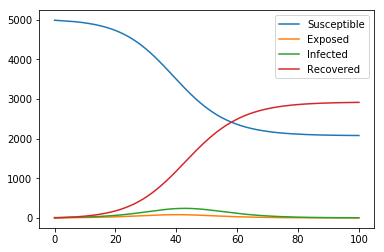

In [5]:
#solve seir model
ini_state=[4990,0,10,0]
t_max=100
dt=0.01
t=np.arange(0,t_max,dt)
plt.plot(t,odeint(seir_eq,ini_state,t,args=(0.0001,1,3)))
plt.legend(['Susceptible','Exposed','Infected','Recovered'])

このグラフから何が言えるでしょう。上記のパラメータを有する感染症は、5000人中10人だけの感染者が集団に紛れ込んだだけでも、最終的には3000人以上と半分以上の人が感染を経験するということがわかります。このように、感染症が持つパラメータがわかっている場合は、感染者が集団に与える影響を評価することが可能になります。

## パラメータ推定（最尤法）
では、パラメータはどのように評価すればよいでしょうか。これは実際の感染症のデータから推定が可能です。今回は感染者数に関して以下のデータが得られていると仮定して、最尤推定によってパラメータの推定をしてみます。

（データは実データではなく、SEIRモデルにある値を入れた際の出力値にガウス分布の乱数エラーを加えたものです）

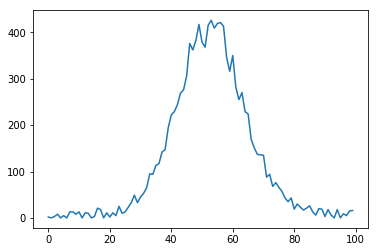

In [6]:
#show observed i
obs_i=np.loadtxt('fitting.csv')
plt.plot(obs_i)

最尤推定の概論を紹介します。最尤推定はデータを用いて最も確からしいθを求める方法で、具体的にはパラメータに依存する数理モデルによって実際の観測データを得る確率が最大となるパラメータの値を推定値とします。推定にあたって、観測データの感染者数の値$I_{obs}(t)$がパラメータを与えたときの数理モデルの感染者数の出力値$\lambda_t(\theta)=I_{est}(t|\theta)$を平均値とするポアソン分布の確率に従って与えられると仮定します。そのような場合、尤度関数は$L(\theta)=\Pi_t exp(-\lambda_t(\theta)) \lambda_t(\theta)^{I{obs}(t)}$となり、計算を容易にするためにlogを作用させると$log L(\theta)=\Sigma_t (-\lambda_t(\theta)+I_{obs}(t) log(\lambda_t(\theta)))$になりますので、これの最大値をもたらすθが今回求める値となります。

実際に最尤推定を行うコードを書いていきます。まず、パラメータを与えたときの数理モデルの感染者数の出力値$\lambda_t(\theta)=I_{est}(t|\theta)$を返す関数を定義します。

In [7]:
#function which estimate i from seir model func 
def estimate_i(ini_state,beta,lp,ip):
    v=odeint(seir_eq,ini_state,t,args=(beta,lp,ip))
    est=v[0:int(t_max/dt):int(1/dt)]
    return est[:,2]

#define logscale likelihood function
def y(params):
    est_i=estimate_i(ini_state,params[0],params[1],params[2])
    return np.sum(est_i-obs_i*np.log(est_i))

次に、Logスケールの尤度関数を定義します。（実際には尤度関数にマイナスを作用したものを定義しています）

In [8]:
#define logscale likelihood function
def y(params):
    est_i=estimate_i(ini_state,params[0],params[1],params[2])
    return np.sum(est_i-obs_i*np.log(est_i))

これで尤度推定をする準備が整いました。初期値を$[\beta,l_p,i_p]=[1.0,1.0,1.0]$を初期値にして、scipy.optimize.minimizeを利用してNerder-Mead法によって実際に上で定義した尤度関数のマイナスを最小化するθを求めます。

In [9]:
#optimize logscale likelihood function
mnmz=minimize(y,[3.0,3.0,3.0],method="nelder-mead")
mnmz

C:\Users\sunoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


 final_simplex: (array([[1.49408485e-04, 5.28989051e+00, 2.89596789e+00],
       [1.49405791e-04, 5.28989313e+00, 2.89604625e+00],
       [1.49406399e-04, 5.28989317e+00, 2.89604522e+00],
       [1.49408997e-04, 5.28989109e+00, 2.89598496e+00]]), array([-50537.90941176, -50537.90941155, -50537.90940887, -50537.90940583]))
           fun: -50537.909411759916
       message: 'Optimization terminated successfully.'
          nfev: 293
           nit: 157
        status: 0
       success: True
             x: array([1.49408485e-04, 5.28989051e+00, 2.89596789e+00])

これでパラメータの推定値は得られました。推定された値をモデルに入れた際の出力を元の観測データと比較すると以下の通りです。再現度はそこそこといったところかと思います。

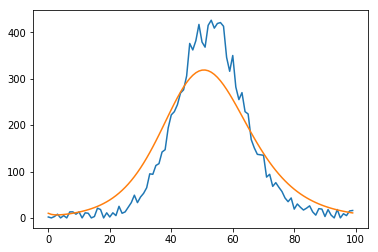

In [10]:
#plot reult with observed data
plt.plot(obs_i)
plt.plot(estimate_i(ini_state,mnmz.x[0],mnmz.x[1],mnmz.x[2]))

この結果を用いてS,E,I,Rのすべてを出力すると以下の通りです。

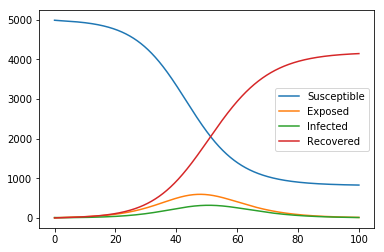

In [11]:
plt.plot(t,odeint(seir_eq,ini_state,t,args=(mnmz.x[0],mnmz.x[1],mnmz.x[2])))
plt.legend(['Susceptible','Exposed','Infected','Recovered'])

このような方法で、Pythonを用いてSEIRモデルの計算ができます。より複雑なモデルを採用する場合も、微分方程式等を調整することで同様に解析を行うことが可能かと思います。もし今後時間と興味が続けば、感染症数理モデルでどんなことがわかるかを記載をしていく予定です。

## 参考にしたサイト
https://ja.wikipedia.org/wiki/SEIR%E3%83%A2%E3%83%87%E3%83%AB

https://www.jstage.jst.go.jp/article/jve/19/1/19_48/_pdf/-char/ja